# Implementation For Emerging Markets
## State Variable:

- Price: MSCI Emerging Market Index (Bloomberg)
- Volatility: Realized volatility directly computed on the MSCI Emerging Market Index
- 10y rates:
- 3m rates: U.S rate (assuming emerging markets have a high dependence on the dollar)
- Oil: Same as U.S
- Copper: Same as U.S

Used Fama French 6 Factors for now.

## Results:
The overall similarity strategy looks to work in this market too despite the fact that the highest SR is not the most similar days Q1. Investigate:

Maha seems to enhance the economic intuition by improving significantly the performance of Q1. But reducing the performance of the rest.

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn            as sns
data = pd.read_excel("Regimes\Data\Emerging Markets\em.xlsx")
data.head()

,Date,MSCI Emerging Market,Vol Emerging Market,JPEGSOSR Index,PGCRDUBA Index,BSBY3M Index
0,1928-12-31,NaN,NaN,#N/A Invalid Security,NaN,NaN
1,1929-01-01,NaN,NaN,NaN,NaN,NaN
2,1929-01-02,NaN,NaN,NaN,NaN,NaN
3,1929-01-03,NaN,NaN,NaN,NaN,NaN
4,1929-01-04,NaN,NaN,NaN,NaN,NaN


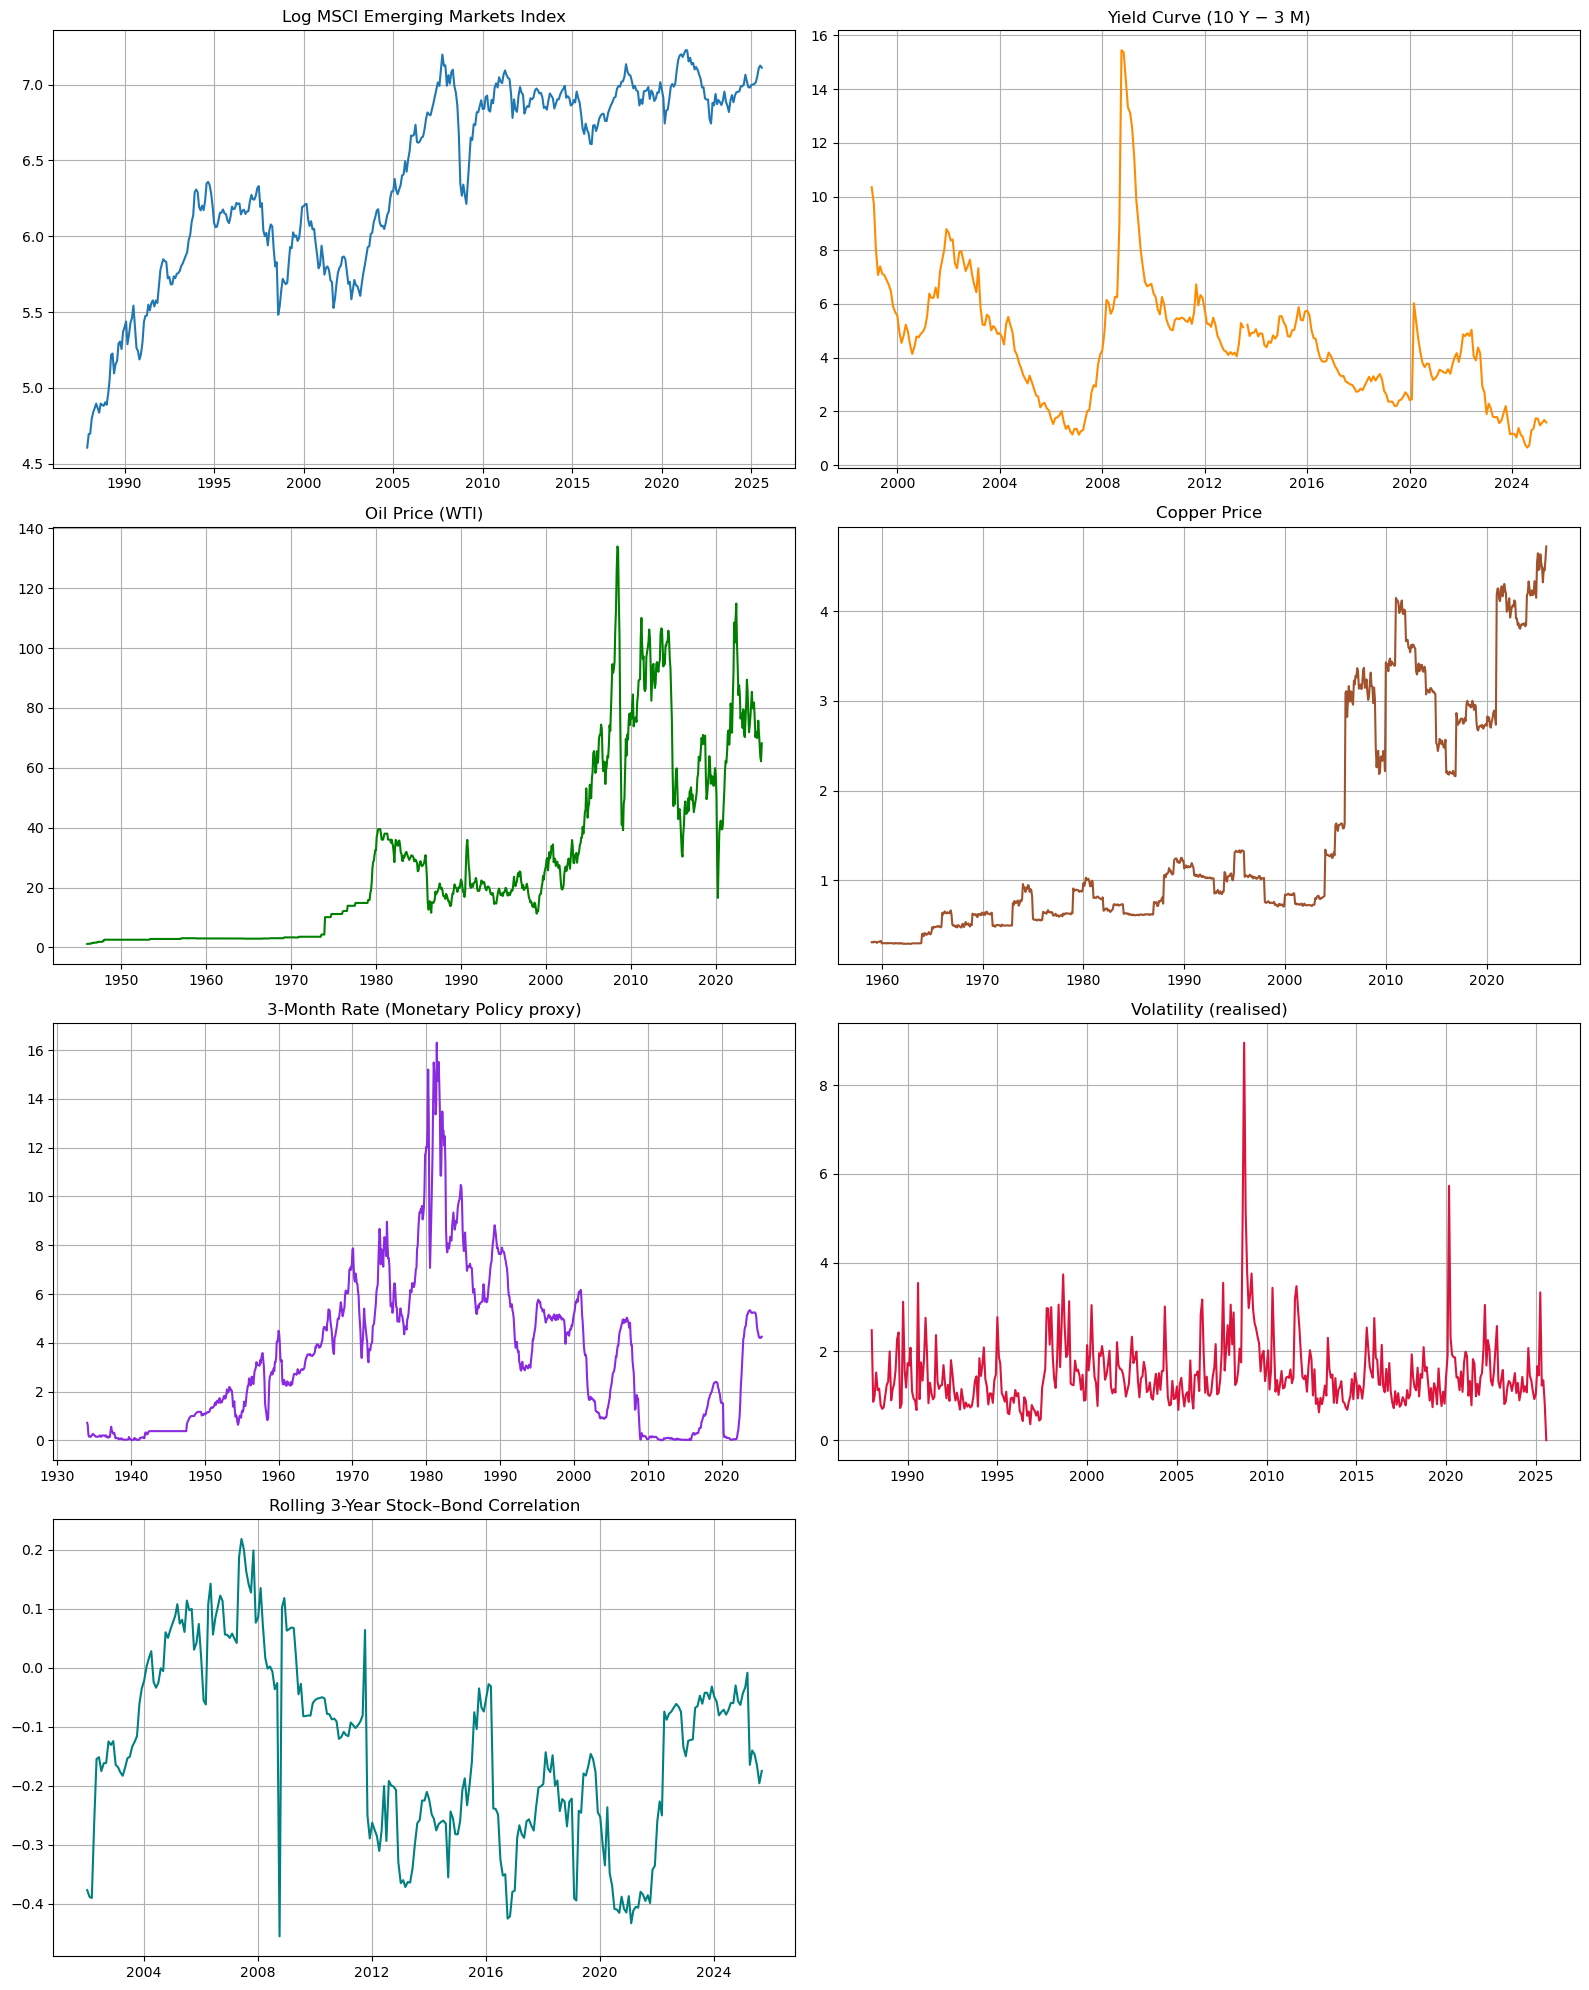

In [32]:
log = np.log                  
to_ts = lambda p: p.to_timestamp(how="end")

# ------------------------------------------------------------------
# 1.  MSCI EM  (daily ➜ monthly log-price & returns)
# ------------------------------------------------------------------
df_em = data.copy()
df_em["Date"] = pd.to_datetime(df_em["Date"])
df_em["ret_mkt"] = log(df_em["MSCI Emerging Market"]).diff()
df_em["Month"]   = df_em["Date"].dt.to_period("M")

mkt_monthly = (df_em.groupby("Month")
                 .tail(1)                      
                 .reset_index(drop=True))

mkt_monthly["EM_Return"]   = log(mkt_monthly["MSCI Emerging Market"]).diff()
mkt_monthly["Log_EM_Price"] = log(mkt_monthly["MSCI Emerging Market"])

var_mkt_em = mkt_monthly[["Month",
                          "MSCI Emerging Market",
                          "EM_Return",
                          "Log_EM_Price"]].copy()

# ------------------------------------------------------------------
# 2.  10-YEAR EM Sovereign Yield  (daily ➜ monthly)
# ------------------------------------------------------------------
bond_daily = (pd.read_excel("Regimes\Data\Emerging Markets\Ten year EM.xlsx",   # ← adjust path
                            parse_dates=["Date"])
                .rename(columns=str.strip))

bond_daily["TenYear"] = pd.to_numeric(bond_daily["TenYear"], errors="coerce")
bond_daily["Month"]   = bond_daily["Date"].dt.to_period("M")

tenyear_monthly = (bond_daily.groupby("Month")
                                 .tail(1)       # month-end value
                                 .reset_index(drop=True)
                                 [["Month", "TenYear"]])

# ------------------------------------------------------------------
# 3.  3-MONTH bill  (U.S. 3-m series for now)
# ------------------------------------------------------------------
var_3m = (pd.read_csv("Regimes\Data\Emerging Markets\ThreemUS.csv",
                      usecols=["observation_date", "TB3MS"])
            .rename(columns={"observation_date": "Date",
                             "TB3MS": "ThreeMonth"}))
var_3m["Date"] = pd.to_datetime(var_3m["Date"])
var_3m["ThreeMonth"] = pd.to_numeric(var_3m["ThreeMonth"], errors="coerce")
var_3m["Month"] = var_3m["Date"].dt.to_period("M")
var_3m = var_3m[["Month", "ThreeMonth"]]

# ------------------------------------------------------------------
# 4.  Yield-curve variables  (10y − 3m,  Δ10y)
# ------------------------------------------------------------------
merged_em = (tenyear_monthly
               .merge(var_3m, on="Month", how="inner")
               .sort_values("Month"))

merged_em["YieldCurve"]  = merged_em["TenYear"] - merged_em["ThreeMonth"]
merged_em["YieldChange"] = merged_em["TenYear"].diff()

# ------------------------------------------------------------------
# 5.  OIL  (unchanged)
# ------------------------------------------------------------------
var_oil = (pd.read_csv("Regimes\Data\Original Reproduction\Oil U.S.csv")
             .rename(columns={"observation_date": "Date",
                              "WTISPLC": "Oil Price"}))
var_oil["Date"] = pd.to_datetime(var_oil["Date"])
var_oil["Oil Price"] = pd.to_numeric(var_oil["Oil Price"], errors="coerce")
var_oil["Month"] = var_oil["Date"].dt.to_period("M")

oil_monthly = (var_oil.groupby("Month")["Oil Price"]
                         .mean()
                         .reset_index())

# ------------------------------------------------------------------
# 6.  COPPER  (unchanged)
# ------------------------------------------------------------------
var_copper = pd.read_csv("Regimes\Data\Original Reproduction\copper-prices-historical-chart-data.csv")
var_copper.columns = ["Date", "Copper"]
var_copper["Date"]   = pd.to_datetime(var_copper["Date"], dayfirst=True, errors="coerce")
var_copper["Copper"] = pd.to_numeric(var_copper["Copper"], errors="coerce")
var_copper["Month"]  = var_copper["Date"].dt.to_period("M")

copper_monthly = (var_copper.groupby("Month")["Copper"]
                               .mean()
                               .reset_index())

# ------------------------------------------------------------------
# 7.  Volatility  – realised σ from MSCI EM 
# ------------------------------------------------------------------
def realised_vol(x):
    return x.std(ddof=0) * np.sqrt(252) * 10        

vol_monthly = (df_em.groupby("Month")["ret_mkt"]
                         .agg(realised_vol)
                         .reset_index()
                         .rename(columns={"ret_mkt": "VolProxy"}))

# ------------------------------------------------------------------
# 8.  Stock–Bond correlation (MSCI EM vs 10-y Δy, monthly 36-m window)
# ------------------------------------------------------------------
df_sb = (df_em[["Date", "ret_mkt"]]
           .merge(bond_daily[["Date", "TenYear"]], on="Date", how="inner")
           .dropna())

df_sb["d_y"] = df_sb["TenYear"].diff() / 100.0
df_sb.dropna(inplace=True)

df_sb["Month"] = df_sb["Date"].dt.to_period("M")

eq_m = df_sb.groupby("Month")["ret_mkt"].sum()
dy_m = df_sb.groupby("Month")["d_y"].last()

sb_month = (pd.concat([eq_m, dy_m], axis=1)
              .dropna()
              .reset_index())

sb_month["StockBondCorr"] = (sb_month["ret_mkt"]
                               .rolling(36, min_periods=36)
                               .corr(sb_month["d_y"]))

var_correl_em = sb_month.dropna(subset=["StockBondCorr"])[
                    ["Month", "StockBondCorr"]]


fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

# 1. Log MSCI Emerging Markets
latest_em = var_mkt_em.drop_duplicates("Month", keep="last")
axes[0].plot(latest_em["Month"].dt.to_timestamp(),
             np.log(latest_em["MSCI Emerging Market"]),
             label="Log MSCI EM")
axes[0].set_title("Log MSCI Emerging Markets Index")
axes[0].grid()

# 2. Yield Curve (10-Y – 3-M)
axes[1].plot(merged_em["Month"].dt.to_timestamp(),
             merged_em["YieldCurve"],
             label="Yield Curve",
             color="darkorange")
axes[1].set_title("Yield Curve (10 Y − 3 M)")
axes[1].grid()

# 3. Oil price (WTI)
axes[2].plot(oil_monthly["Month"].dt.to_timestamp(),
             oil_monthly["Oil Price"],
             label="Oil Price",
             color="green")
axes[2].set_title("Oil Price (WTI)")
axes[2].grid()

# 4. Copper price
axes[3].plot(copper_monthly["Month"].dt.to_timestamp(),
             copper_monthly["Copper"],
             label="Copper Price",
             color="sienna")
axes[3].set_title("Copper Price")
axes[3].grid()

# 5. 3-Month short rate (placeholder: U.S. T-bill)
axes[4].plot(var_3m["Month"].dt.to_timestamp(how="end"),
             var_3m["ThreeMonth"],
             label="3 M Rate",
             color="blueviolet")
axes[4].set_title("3-Month Rate (Monetary Policy proxy)")
axes[4].grid()

# 6. Realised volatility (MSCI EM)
axes[5].plot(vol_monthly["Month"].dt.to_timestamp(),
             vol_monthly["VolProxy"],
             label="Realised σ",
             color="crimson")
axes[5].set_title("Volatility (realised)")
axes[5].grid()

# 7. Rolling 3-year stock–bond correlation
axes[6].plot(var_correl_em["Month"].dt.to_timestamp(how="end"),
             var_correl_em["StockBondCorr"],
             label="Stock–Bond Corr.",
             color="teal")
axes[6].set_title("Rolling 3-Year Stock–Bond Correlation")
axes[6].grid()

axes[7].axis("off")

plt.tight_layout()
plt.show()



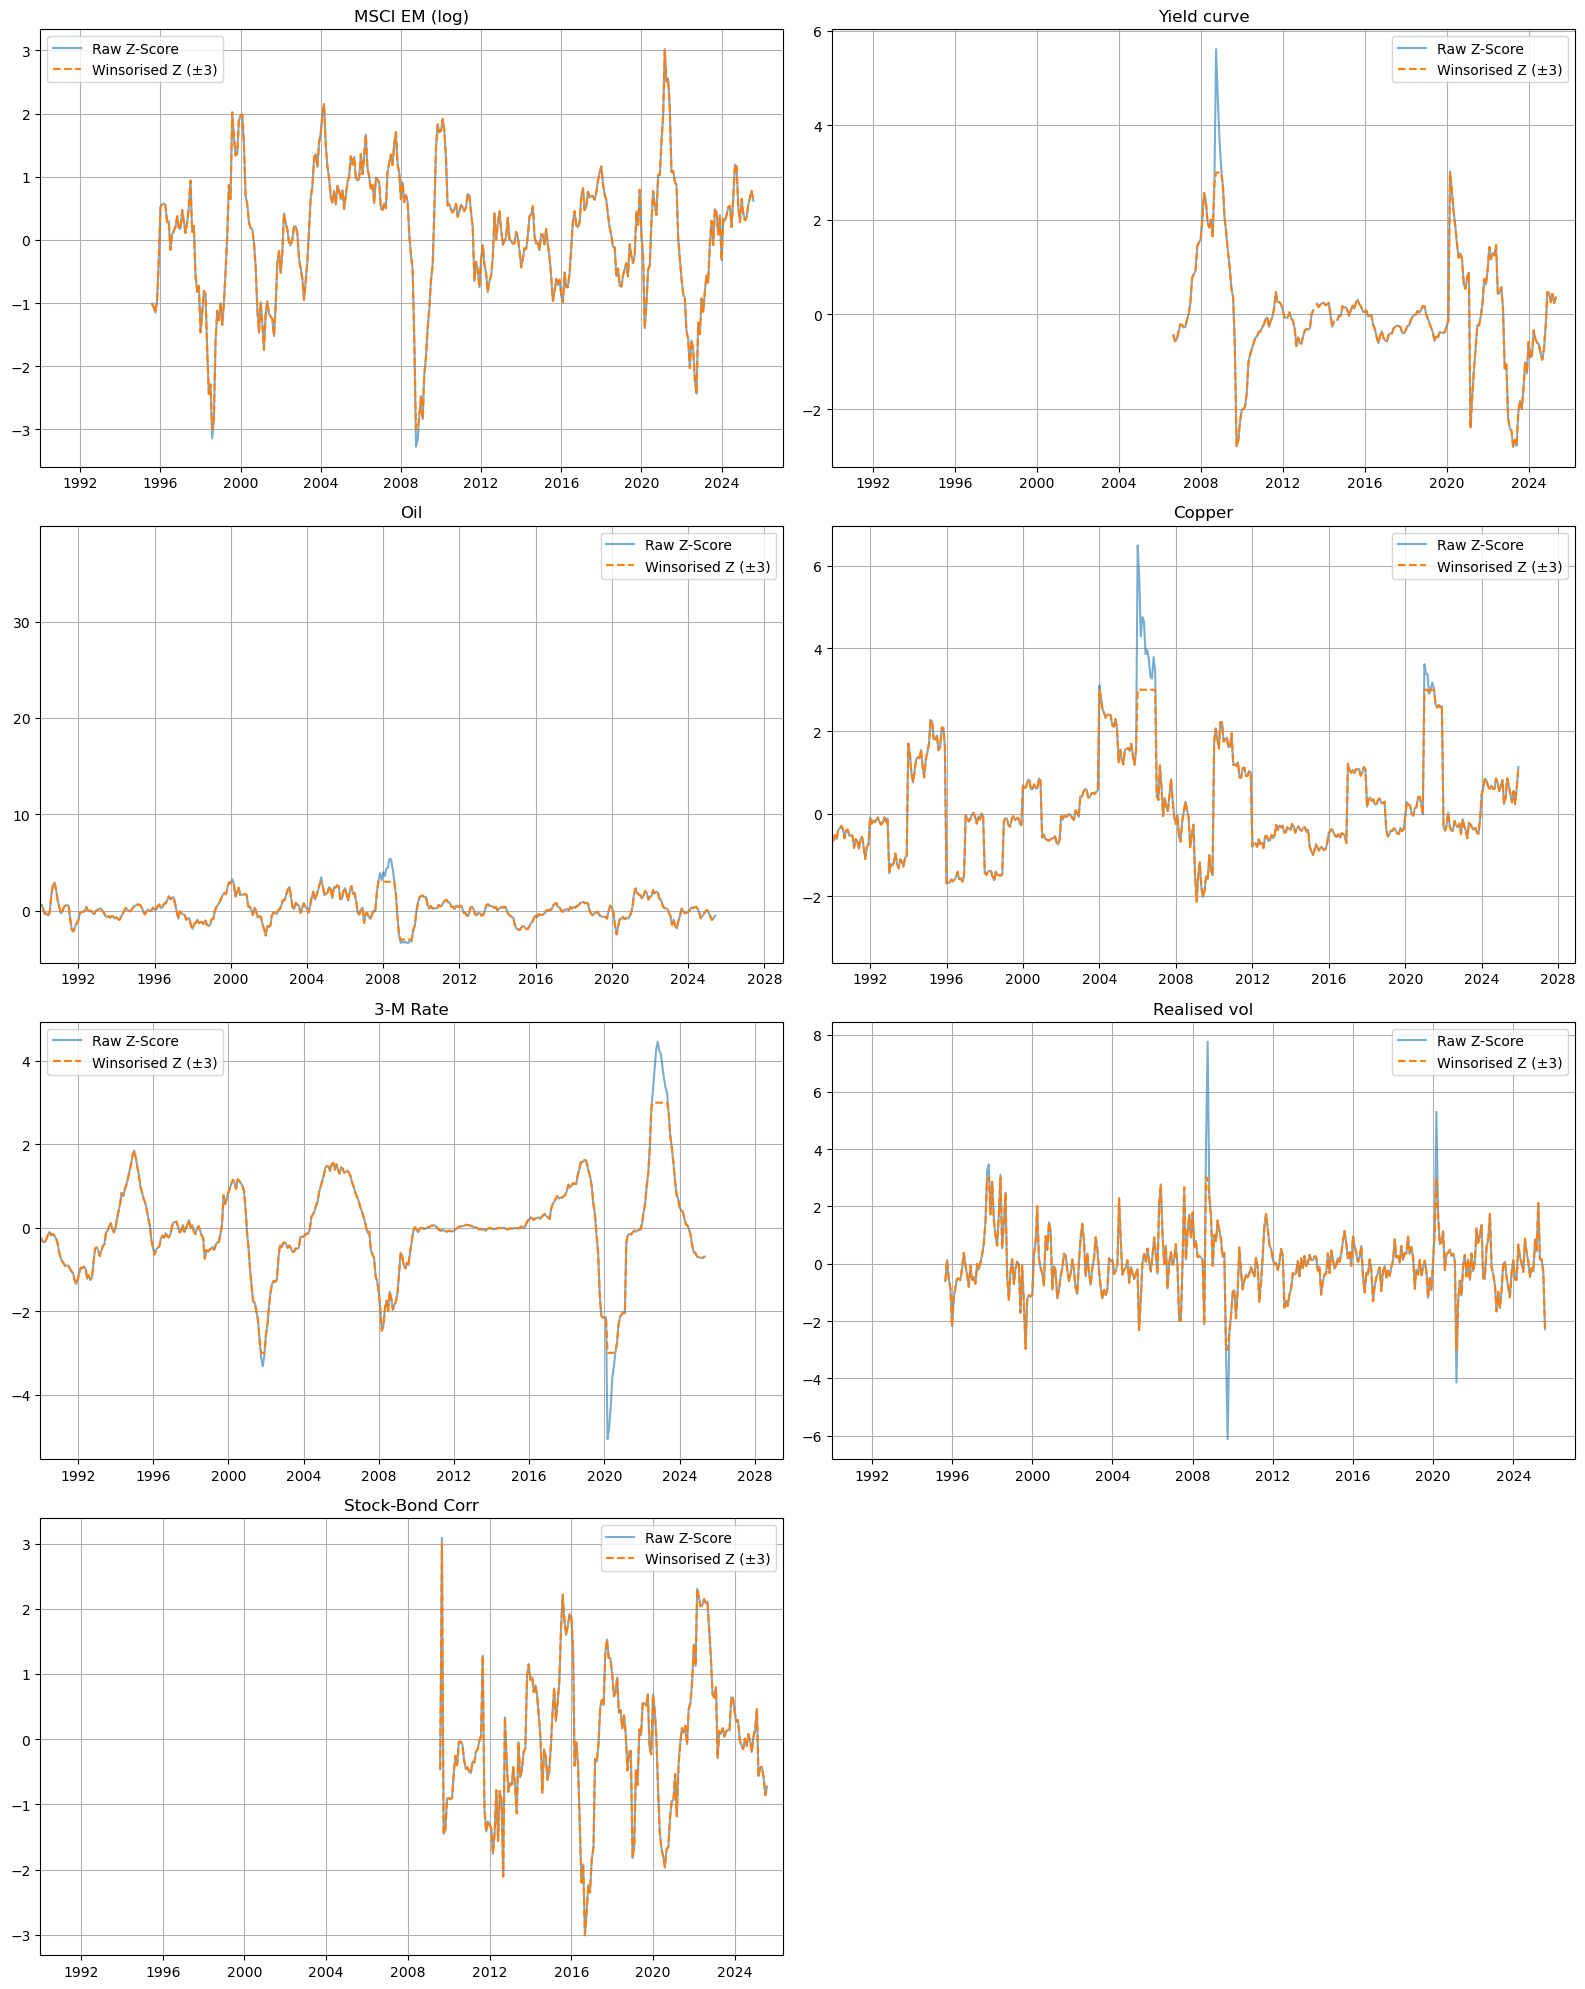

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def compute_z_and_winsorized(df, date_col, value_col, window_months=120):
    df = df.copy().sort_values(date_col)
    df["Diff12"]  = df[value_col] - df[value_col].shift(12)
    df["RollStd"] = (df["Diff12"]
                     .shift(1)
                     .rolling(window_months, min_periods=80)
                     .std())
    df["ZScore"]  = df["Diff12"] / df["RollStd"]
    df["ZScoreWinsorized"] = df["ZScore"].clip(-3, 3)
    return df[[date_col, "ZScore", "ZScoreWinsorized"]]


series_info_em = {
    "MSCI EM (log)":       ("em_log",      var_mkt_em,      "Month", "Log_EM_Price"),
    "Yield curve":         ("yield_curve", merged_em,       "Month", "YieldCurve"),
    "Oil":                 ("oil",         oil_monthly,     "Month", "Oil Price"),
    "Copper":              ("copper",      copper_monthly,  "Month", "Copper"),
    "3-M Rate":            ("three_month", var_3m,          "Month", "ThreeMonth"),
    "Realised vol":        ("vol",         vol_monthly,     "Month", "VolProxy"),
    "Stock-Bond Corr":     ("sb_corr",     var_correl_em,   "Month", "StockBondCorr"),
}


fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, (title, (_, df_src, date_col, value_col)) in enumerate(series_info_em.items()):
    z_df = compute_z_and_winsorized(df_src, date_col, value_col)
    axes[i].plot(z_df[date_col].dt.to_timestamp(),
                 z_df["ZScore"],
                 label="Raw Z-Score", alpha=0.6)
    axes[i].plot(z_df[date_col].dt.to_timestamp(),
                 z_df["ZScoreWinsorized"],
                 label="Winsorised Z (±3)", ls="--")
    axes[i].set_title(title)
    axes[i].set_xlim(left=pd.Timestamp("1990-01-01"))   
    axes[i].grid(True)
    axes[i].legend()

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [10]:

market_monthly_em  = (var_mkt_em
                        .loc[:, ["Month", "Log_EM_Price"]]
                        .rename(columns={"Log_EM_Price": "Value"}))

yield_monthly_em   = (merged_em
                        .loc[:, ["Month", "YieldCurve"]]
                        .rename(columns={"YieldCurve": "Value"}))

oil_monthly_clean  =  oil_monthly.rename(columns={"Oil Price": "Value"})
copper_monthly_clean = copper_monthly.rename(columns={"Copper": "Value"})

monthly_3m_em = (var_3m
                   .loc[:, ["Month", "ThreeMonth"]]
                   .rename(columns={"ThreeMonth": "Value"}))

vol_monthly_clean = vol_monthly.rename(columns={"VolProxy": "Value"})

stockbond_monthly_em = (var_correl_em
                          .loc[:, ["Month", "StockBondCorr"]]
                          .rename(columns={"StockBondCorr": "Value"}))

series_dict_em = {
    "Market":              market_monthly_em,
    "Yield curve":         yield_monthly_em,
    "Oil":                 oil_monthly_clean,
    "Copper":              copper_monthly_clean,
    "3-M Rate":            monthly_3m_em,
    "Volatility":          vol_monthly_clean,
    "Stock-Bond Corr":     stockbond_monthly_em,
}


lags = [1, 3, 12, 36, 120]         
rows = []

for var_name, df_val in series_dict_em.items():
    z_df = (compute_z_and_winsorized(df_val, "Month", "Value")
            .dropna(subset=["ZScoreWinsorized"])
            .reset_index(drop=True))

    if len(z_df) < max(lags) + 1:
        acs    = [np.nan] * len(lags)
        mean_z = std_z = np.nan
    else:
        acs    = [z_df["ZScoreWinsorized"].autocorr(lag=l) for l in lags]
        mean_z = z_df["ZScoreWinsorized"].mean()
        std_z  = z_df["ZScoreWinsorized"].std(ddof=1)

    rows.append({
        "Variable":     var_name,
        "1 month":      acs[0],
        "3 month":      acs[1],
        "12 month":     acs[2],
        "3 year":       acs[3],
        "10 year":      acs[4],
        "monthly mean": mean_z,
        "std":          std_z,
        "frequency":    "monthly",
    })

summary_table_em = (pd.DataFrame(rows)
    .loc[:, ["Variable", "1 month", "3 month", "12 month",
             "3 year", "10 year", "monthly mean", "std", "frequency"]])

num_cols = ["1 month", "3 month", "12 month",
            "3 year", "10 year", "monthly mean", "std"]
summary_table_em[num_cols] = summary_table_em[num_cols].round(2)
summary_table_em


,Variable,1 month,3 month,12 month,3 year,10 year,monthly mean,std,frequency
0,Market,0.93,0.74,-0.26,0.14,0.23,0.10,1.00,monthly
1,Yield curve,0.92,0.74,-0.15,-0.11,-0.10,-0.00,1.10,monthly
2,Oil,0.93,0.73,-0.04,0.15,-0.02,0.33,1.19,monthly
3,Copper,0.91,0.75,0.08,-0.08,0.02,0.22,1.19,monthly
4,3-M Rate,0.96,0.82,0.02,-0.18,0.06,0.19,1.24,monthly
5,Volatility,0.58,0.24,-0.40,-0.01,0.12,0.01,0.98,monthly
6,Stock-Bond Corr,0.80,0.67,-0.30,-0.32,-0.35,-0.06,1.06,monthly


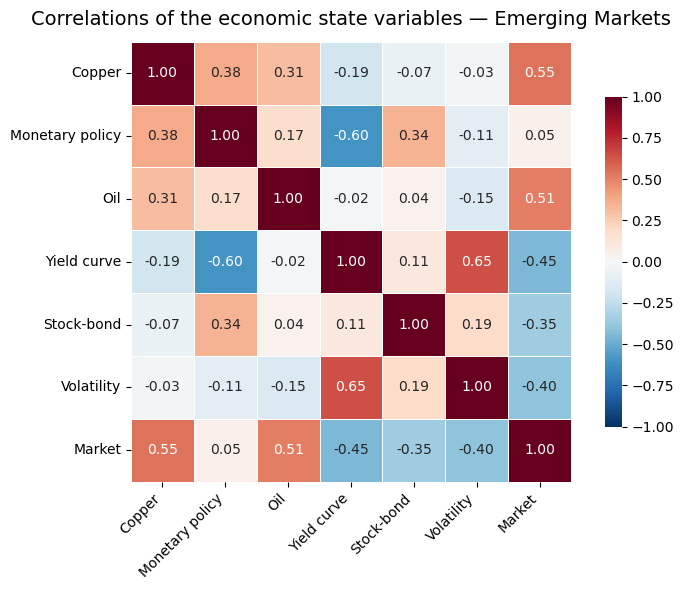

In [11]:

z_market  = (compute_z_and_winsorized(market_monthly_em,   'Month', 'Value')
               .rename(columns={'ZScoreWinsorized':'Market'})[['Month','Market']])

z_yield   = (compute_z_and_winsorized(yield_monthly_em,    'Month', 'Value')
               .rename(columns={'ZScoreWinsorized':'Yield curve'})[['Month','Yield curve']])

z_oil     = (compute_z_and_winsorized(oil_monthly_clean,   'Month', 'Value')
               .rename(columns={'ZScoreWinsorized':'Oil'})[['Month','Oil']])

z_copper  = (compute_z_and_winsorized(copper_monthly_clean,'Month', 'Value')
               .rename(columns={'ZScoreWinsorized':'Copper'})[['Month','Copper']])

z_3m      = (compute_z_and_winsorized(monthly_3m_em,       'Month', 'Value')
               .rename(columns={'ZScoreWinsorized':'Monetary policy'})[['Month','Monetary policy']])

z_vol     = (compute_z_and_winsorized(vol_monthly_clean,   'Month', 'Value')
               .rename(columns={'ZScoreWinsorized':'Volatility'})[['Month','Volatility']])

z_sb      = (compute_z_and_winsorized(stockbond_monthly_em,'Month', 'Value')
               .rename(columns={'ZScoreWinsorized':'Stock-bond'})[['Month','Stock-bond']])

df_period_em = (z_market
    .merge(z_yield, on='Month', how='outer')
    .merge(z_oil,   on='Month', how='outer')
    .merge(z_copper,on='Month', how='outer')
    .merge(z_3m,    on='Month', how='outer')
    .merge(z_vol,   on='Month', how='outer')
    .merge(z_sb,    on='Month', how='outer'))

corr_mat_em = df_period_em.drop(columns='Month').corr()

row_order = [
    'Copper',
    'Monetary policy',
    'Oil',
    'Yield curve',
    'Stock-bond',
    'Volatility',
    'Market'
]
corr_mat_em = corr_mat_em.loc[row_order, row_order]

plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat_em,
            annot=True, fmt='.2f',
            center=0, cmap='RdBu_r',
            vmin=-1, vmax=1,
            square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.75})
plt.title('Correlations of the economic state variables — Emerging Markets',
          fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [12]:
def find_similar_months(
    df_period: pd.DataFrame,
    target: str,
    exclude_last_n: int = 36,
    bottom_pct: float = 0.15
) -> pd.DataFrame:
    
    T_period = pd.Period(target, freq='M')

    
    cutoff_period = T_period - exclude_last_n  

    mask = df_period.index <= cutoff_period

    df_candidates = df_period.loc[mask].copy()

    df_candidates = df_candidates.dropna(how='any')

    z_T = df_period.loc[T_period].values   

    mat = df_candidates.values               
    diffs = mat - z_T.reshape(1, -1)        
    sq    = diffs**2
    dist  = np.sqrt(sq.sum(axis=1))          

    out = pd.DataFrame({
        'Distance': dist
    }, index=df_candidates.index)
    out = out.sort_values('Distance', ascending=True)
    out['Rank'] = np.arange(1, len(out) + 1)

    n_select = int(np.floor(bottom_pct * len(out)))
    n_select = max(n_select, 1)  
    out['IsBottom'] = False
    out.iloc[:n_select, out.columns.get_indexer(['IsBottom'])] = True

    result_df = out.reset_index().rename(columns={'index': 'Month'})

    return result_df

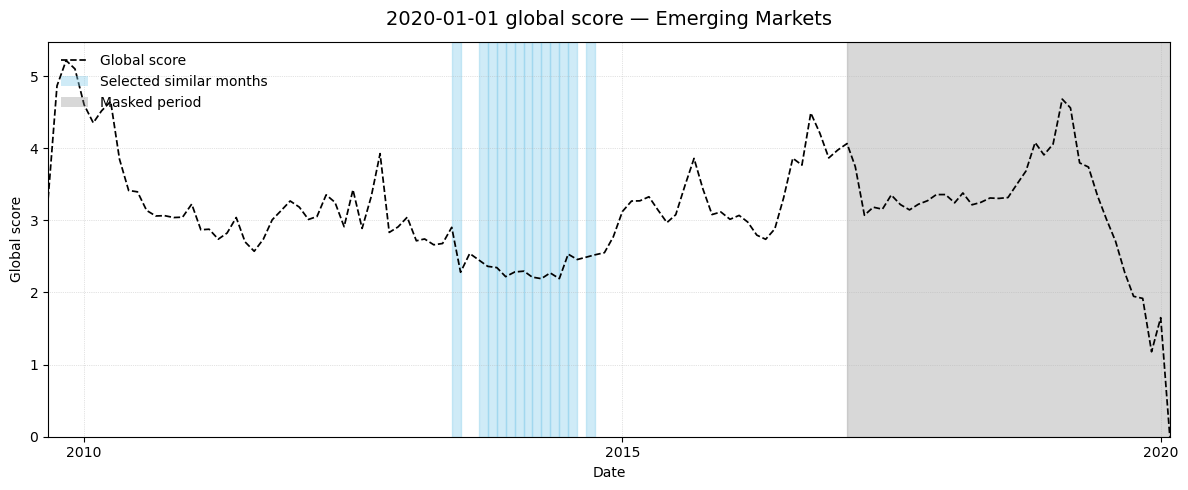

In [13]:
from  matplotlib.patches import Rectangle

target_month   = "2020-01"  
bottom_pct     = 0.15        
exclude_last_n = 36          

if "Month" in df_period_em.columns:
    df_period_em = df_period_em.set_index("Month")


sim_full = find_similar_months(
              df_period      = df_period_em,
              target         = target_month,
              exclude_last_n = 0,          # full history
              bottom_pct     = bottom_pct)

sim_mask = find_similar_months(
              df_period      = df_period_em,
              target         = target_month,
              exclude_last_n = exclude_last_n,
              bottom_pct     = bottom_pct)

ts_dist = (sim_full.set_index("Month")["Distance"]
                     .sort_index()
                     .rename("Global score"))
ts_dist.index = ts_dist.index.to_timestamp(how="end")

selected = sim_mask[sim_mask["IsBottom"]].copy()
selected["start"] = selected["Month"].dt.to_timestamp(how="start")
selected["end"]   = selected["Month"].dt.to_timestamp(how="end")

T_per        = pd.Period(target_month, freq="M")
cutoff       = T_per - exclude_last_n
mask_start   = (cutoff + 1).to_timestamp(how="start")
mask_end     = T_per.to_timestamp(how="end")


plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.plot(ts_dist.index, ts_dist.values,
        ls="--", color="black", lw=1.25,
        label="Global score")

for _, row in selected.iterrows():
    ax.axvspan(row["start"], row["end"],
               color="skyblue", alpha=0.4)

ax.axvspan(mask_start, mask_end, color="gray", alpha=0.3)

proxy_sim  = Rectangle((0, 0), 1, 1, facecolor="skyblue", alpha=0.4)
proxy_mask = Rectangle((0, 0), 1, 1, facecolor="gray",    alpha=0.3)
ax.legend(handles=[ax.lines[0], proxy_sim, proxy_mask],
          labels=["Global score",
                  "Selected similar months",
                  "Masked period"],
          loc="upper left", frameon=False)

ax.set_title(f"{target_month}-01 global score — Emerging Markets",
             fontsize=14, pad=12)
ax.set_ylabel("Global score")
ax.set_xlabel("Date")
ax.set_ylim(bottom=0)
ax.set_xlim(left=ts_dist.index.min(), right=ts_dist.index.max())
ax.grid(ls=":", lw=0.5, alpha=0.7)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [33]:
ff_5f = pd.read_csv("Regimes\Data\Emerging Markets\Emerging_5_Factors.csv",skiprows=3,engine='python').rename(columns={"Unnamed: 0": "Date"})
ff_mom = pd.read_csv("Regimes\Data\Emerging Markets\Emerging_MOM_Factor.csv",skiprows=3,engine='python').rename(columns={"Unnamed: 0": "Date"})

In [17]:

concat_fff_em = (
    pd.merge(ff_5f, ff_mom, on="Date", how="inner")     
      .rename(columns={"WML": "Mom"})    # clarify cols
      .assign(Date=lambda d: d["Date"].astype(str).str.strip())
      .loc[lambda d: d["Date"].str.fullmatch(r"\d{6}")]        
)


concat_fff_em["Month"] = pd.to_datetime(concat_fff_em["Date"], format="%Y%m").dt.to_period("M")
concat_fff_em = concat_fff_em.set_index("Month").drop(columns="Date").sort_index()

factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom"]
concat_fff_em[factor_cols] = concat_fff_em[factor_cols].apply(pd.to_numeric, errors="coerce") / 100
concat_fff_em["RF"]        = pd.to_numeric(concat_fff_em["RF"], errors="coerce") / 100

print(concat_fff_em.head())

         Mkt-RF     SMB     HML     RMW     CMA      RF     Mom
Month                                                          
1990-01  0.0102  0.0824  0.1296 -0.9999 -0.9999  0.0057  0.0545
1990-02  0.0376  0.0535  0.0264 -0.9999 -0.9999  0.0057  0.0207
1990-03 -0.0507 -0.0187  0.0288 -0.9999 -0.9999  0.0064 -0.0190
1990-04 -0.0112  0.0176 -0.0717 -0.9999 -0.9999  0.0069 -0.0448
1990-05  0.0813 -0.0196  0.0503 -0.9999 -0.9999  0.0068  0.0523


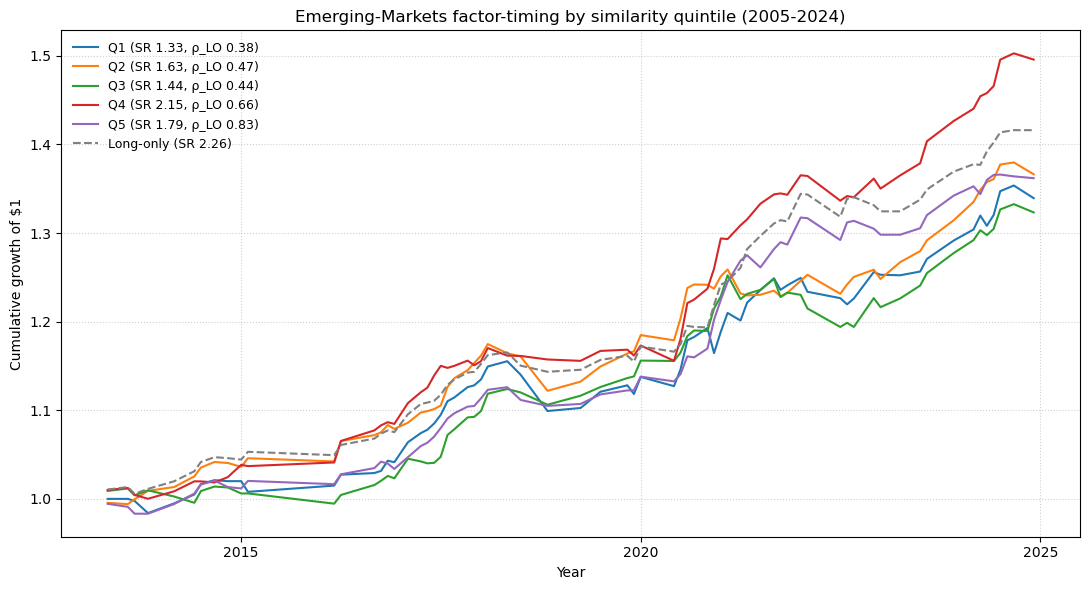

In [20]:


lookback_gap  = 36
factors       = ['Mkt-RF','SMB','HML','RMW','CMA','Mom']
colors        = {1:"tab:blue",2:"tab:orange",3:"tab:green",
                 4:"tab:red",5:"tab:purple"}

BACKTEST_START = pd.Period('2013-01', freq='M')   # <- EM coverage window
BACKTEST_END   = pd.Period('2024-12', freq='M')


def quintile_members(df_period: pd.DataFrame, target_per: pd.Period):
    full = (find_similar_months(df_period, str(target_per),
                                exclude_last_n=lookback_gap,
                                bottom_pct=1.0)
              .sort_values('Distance'))
    n = len(full)
    if n == 0:
        return {q: np.array([]) for q in range(1,6)}

    k20 = int(0.20*n)
    q1  = full.iloc[:k20]['Month'].to_numpy()
    q5  = full.iloc[-k20:]['Month'].to_numpy()
    q2,q3,q4 = np.array_split(full.iloc[k20:-k20]['Month'].to_numpy(),3)

    return {1:q1, 2:q2, 3:q3, 4:q4, 5:q5}

def signal_for_quintile(df_period, target_per, quintile):
    months = quintile_members(df_period, target_per)[quintile]
    if len(months)==0:
        return {f:0 for f in factors}
    idx = pd.PeriodIndex(months, freq='M') + 1      # trade next month
    signs={}
    for f in factors:
        rets = concat_fff_em.loc[concat_fff_em.index.intersection(idx), f]
        signs[f] = np.sign(rets.mean()) if not rets.empty else 0
    return signs


if 'Month' in df_period_em.columns:
    df_period_em = df_period_em.set_index('Month')

first_possible = df_period_em.index.min() + (lookback_gap+1)
hist_start     = max(BACKTEST_START, first_possible)
hist_end       = min(BACKTEST_END, concat_fff_em.index.max())

all_months = concat_fff_em.index.sort_values()
start_idx  = next(i for i,p in enumerate(all_months) if p>=hist_start)
stop_idx   = next(i for i,p in enumerate(all_months) if p>hist_end)-1

returns_by_q = {q: [] for q in range(1,6)}

for i in range(start_idx, stop_idx):
    cur_per, nxt_per = all_months[i], all_months[i+1]
    r = concat_fff_em.loc[nxt_per, factors]

    for q in range(1,6):
        sig = signal_for_quintile(df_period_em, cur_per, q)
        ret = np.mean([sig[f]*r[f] for f in factors])
        returns_by_q[q].append({'Date': nxt_per, 'Return': ret})

q_df = {q: pd.DataFrame(lst).set_index('Date') for q,lst in returns_by_q.items()}

long_only = concat_fff_em[factors].mean(axis=1).loc[q_df[1].index]

ann_sr  = lambda x: (x.mean()/x.std())*np.sqrt(12) if x.std()!=0 else np.nan
corr_lo = lambda x: x.corr(long_only)

stats = {q:(ann_sr(df['Return']),corr_lo(df['Return'])) for q,df in q_df.items()}
sr_lo = ann_sr(long_only)

cum = lambda x: (1+x).cumprod()


plt.figure(figsize=(11,6))
for q in range(1,6):
    plt.plot(q_df[q].index.to_timestamp(how='end'),
             cum(q_df[q]['Return']),
             color=colors[q],
             label=f"Q{q} (SR {stats[q][0]:.2f}, ρ_LO {stats[q][1]:.2f})")

plt.plot(q_df[1].index.to_timestamp(how='end'),
         cum(long_only), color='gray', ls='--',
         label=f"Long-only (SR {sr_lo:.2f})")

plt.title("Emerging-Markets factor-timing by similarity quintile (2005-2024)")
plt.xlabel("Year")
plt.ylabel("Cumulative growth of $1")
plt.legend(frameon=False, fontsize=9)
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()


In [21]:
def find_similar_months_maha(
    df_period: pd.DataFrame,
    target: str,
    exclude_last_n: int = 36,
    bottom_pct: float = 0.15,
    ridge: float = 1e-8         
) -> pd.DataFrame:
    
    T_period = pd.Period(target, freq="M")

    cutoff_period = T_period - exclude_last_n
    df_candidates = (df_period
                     .loc[df_period.index <= cutoff_period]
                     .dropna(how="any")
                     .copy())

    if df_candidates.empty:
        raise ValueError("No candidate months left after masking NA / look-back.")

    X = df_candidates.values
    try:
        inv_cov = inv(np.cov(X, rowvar=False))
    except LinAlgError:
        Σ = np.cov(X, rowvar=False)
        Σ += ridge * np.eye(Σ.shape[0])
        inv_cov = inv(Σ)
    x_T = df_period.loc[T_period].values.reshape(1, -1)
    diffs = X - x_T                            
    d2    = np.einsum("ij,jk,ik->i", diffs, inv_cov, diffs) 
    dist  = np.sqrt(d2)

    out = (pd.DataFrame({"Distance": dist}, index=df_candidates.index)
             .sort_values("Distance"))
    out["Rank"] = np.arange(1, len(out) + 1)

    n_select = max(int(np.floor(bottom_pct * len(out))), 1)
    out["IsBottom"] = False
    out.iloc[:n_select, out.columns.get_loc("IsBottom")] = True

    return out.reset_index().rename(columns={"index": "Month"})


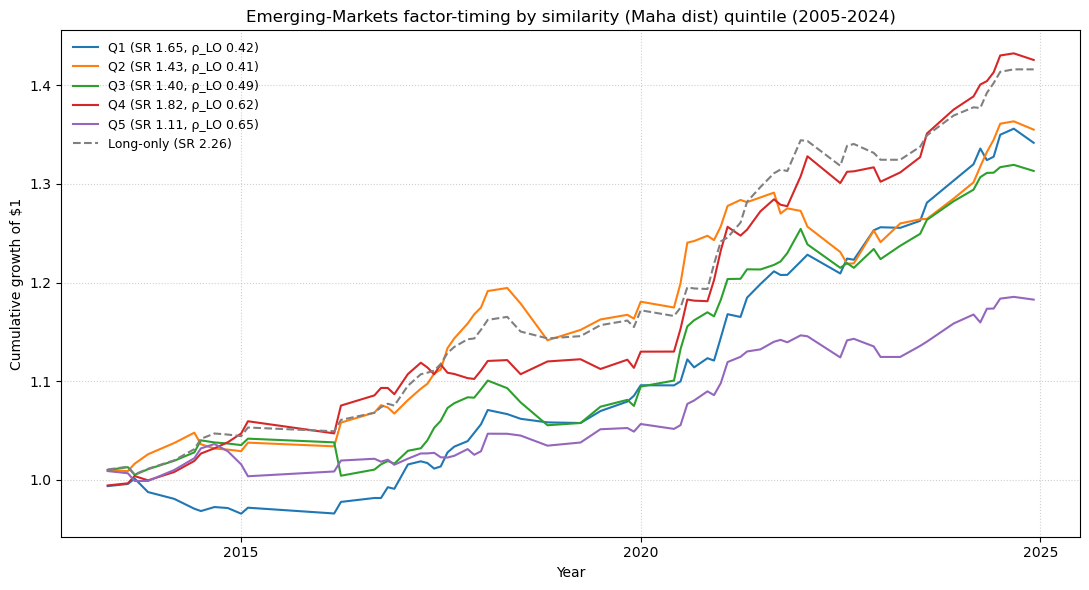

In [25]:
from numpy.linalg import inv, LinAlgError
def find_similar_months_maha(
    df_period: pd.DataFrame,
    target: str,
    exclude_last_n: int = 36,
    bottom_pct: float = 0.15,
    ridge: float = 1e-8,             
) -> pd.DataFrame:

    T_period = pd.Period(target, freq="M")

    cutoff = T_period - exclude_last_n
    df_cand = (df_period
                 .loc[df_period.index <= cutoff]
                 .dropna(how="any")
                 .copy())
    if df_cand.empty:
        raise ValueError("No candidate months after masking.")

    X   = df_cand.values
    Σ   = np.cov(X, rowvar=False)
    Σ  += ridge * np.eye(Σ.shape[0])          
    invΣ = inv(Σ)

    x_T = df_period.loc[T_period].values.reshape(1, -1)
    dif = X - x_T                             
    d2  = np.einsum("ij,jk,ik->i", dif, invΣ, dif)   

    d2  = np.clip(d2, 0, None)               
    dist= np.sqrt(d2)

    out = (pd.DataFrame({"Distance": dist}, index=df_cand.index)
             .sort_values("Distance"))
    out["Rank"] = np.arange(1, len(out) + 1)

    n_keep = max(int(np.floor(bottom_pct * len(out))), 1)
    out["IsBottom"] = False
    out.iloc[:n_keep, out.columns.get_loc("IsBottom")] = True

    return out.reset_index().rename(columns={"index": "Month"})

def quintile_members(df_period: pd.DataFrame, target_per: pd.Period):
    full = (find_similar_months_maha(df_period, str(target_per),
                                exclude_last_n=lookback_gap,
                                bottom_pct=1.0)
              .sort_values('Distance'))
    n = len(full)
    if n == 0:
        return {q: np.array([]) for q in range(1,6)}

    k20 = int(0.20*n)
    q1  = full.iloc[:k20]['Month'].to_numpy()
    q5  = full.iloc[-k20:]['Month'].to_numpy()
    q2,q3,q4 = np.array_split(full.iloc[k20:-k20]['Month'].to_numpy(),3)

    return {1:q1, 2:q2, 3:q3, 4:q4, 5:q5}


if 'Month' in df_period_em.columns:
    df_period_em = df_period_em.set_index('Month')

first_possible = df_period_em.index.min() + (lookback_gap+1)
hist_start     = max(BACKTEST_START, first_possible)
hist_end       = min(BACKTEST_END, concat_fff_em.index.max())

all_months = concat_fff_em.index.sort_values()
start_idx  = next(i for i,p in enumerate(all_months) if p>=hist_start)
stop_idx   = next(i for i,p in enumerate(all_months) if p>hist_end)-1

returns_by_q = {q: [] for q in range(1,6)}

for i in range(start_idx, stop_idx):
    cur_per, nxt_per = all_months[i], all_months[i+1]
    r = concat_fff_em.loc[nxt_per, factors]

    for q in range(1,6):
        sig = signal_for_quintile(df_period_em, cur_per, q)
        ret = np.mean([sig[f]*r[f] for f in factors])
        returns_by_q[q].append({'Date': nxt_per, 'Return': ret})

q_df = {q: pd.DataFrame(lst).set_index('Date') for q,lst in returns_by_q.items()}

long_only = concat_fff_em[factors].mean(axis=1).loc[q_df[1].index]

ann_sr  = lambda x: (x.mean()/x.std())*np.sqrt(12) if x.std()!=0 else np.nan
corr_lo = lambda x: x.corr(long_only)

stats = {q:(ann_sr(df['Return']),corr_lo(df['Return'])) for q,df in q_df.items()}
sr_lo = ann_sr(long_only)

cum = lambda x: (1+x).cumprod()


plt.figure(figsize=(11,6))
for q in range(1,6):
    plt.plot(q_df[q].index.to_timestamp(how='end'),
             cum(q_df[q]['Return']),
             color=colors[q],
             label=f"Q{q} (SR {stats[q][0]:.2f}, ρ_LO {stats[q][1]:.2f})")

plt.plot(q_df[1].index.to_timestamp(how='end'),
         cum(long_only), color='gray', ls='--',
         label=f"Long-only (SR {sr_lo:.2f})")
plt.title("Emerging-Markets factor-timing by similarity (Maha dist) quintile (2005-2024)")
plt.xlabel("Year")
plt.ylabel("Cumulative growth of $1")
plt.legend(frameon=False, fontsize=9)
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()